Hi guys, welcome to social media network analysis, which we do on Kim Kardashian's tweets. I hope you like the kernel in some way or the other

In [1]:
#loading required libraries
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidytext))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(plotly))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(widyr))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ggraph))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(openNLP))
suppressPackageStartupMessages(library(NLP))
suppressPackageStartupMessages(library(tm))
suppressPackageStartupMessages(library(ggmap))
suppressPackageStartupMessages(library(wordcloud))
suppressPackageStartupMessages(library(maps))

ERROR: Error in library(openNLP): there is no package called ‘openNLP’


#Data cleaning

We have to clean the dataset in order to do analysis of the tweets of Kim Kardashian. The task is to respecify the date variable in right order. But, first, we add a new variable called year to find the yearly pattern of the tweets of Kim Kardashian.

In [2]:
dataset <- read.csv("../input/KimKardashianTweets.csv", stringsAsFactors = F, header = T)
#adding new column, default to 2016.
dataset$year <- 2016
#adding the years from the given time.
dataset$year[800:10688] <- substr(dataset$date[800:10688], 7, 11)
#stripping extra whitespace.
dataset$year <- gsub(" ", "", dataset$year)
#converting it, back, into numeric from character.
dataset$year <- as.numeric(dataset$year)

We added the new variable year. It will help us to reorganize the data variable and make it consistent over all the rows of the dataset.

##Kim Kardashian's tweets

All the tweets of Kim Kardashian are available to us in the "text" feature of our dataset. The text should be cleaned, for us, to derive more information from the tweets of Kim kardashian. We clean theses tweets with the help of regex pattern, first, and then proceed further.

In [3]:
#cleaning the text variabkle with regex.
dataset$text <- gsub("[0-9]", "", dataset$text) #all the numeric values
dataset$text <- gsub("RT*", "", dataset$text) #all the RT, if there are.
dataset$text <- gsub("[^\x20-\x7E]", "", dataset$text) #all the unrelated characters
dataset$text <- gsub(" ?(www|ht)tp(s?)://(.*)[.][a-z]+", "", dataset$text) #all the hyperlinks
dataset$text <- gsub("+(pic)?[.]twitter[.]+(.*)", "", dataset$text) #the pics
dataset$text <- gsub("[@#+$//-]", "", dataset$text) #hash's
dataset$text <- gsub("[[:punct:]]", "", dataset$text) #punctuation.

##Which is Kim's favourite time for tweeting?

We look at the distribution of kim's tweets and when is her favourite time to tweet.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


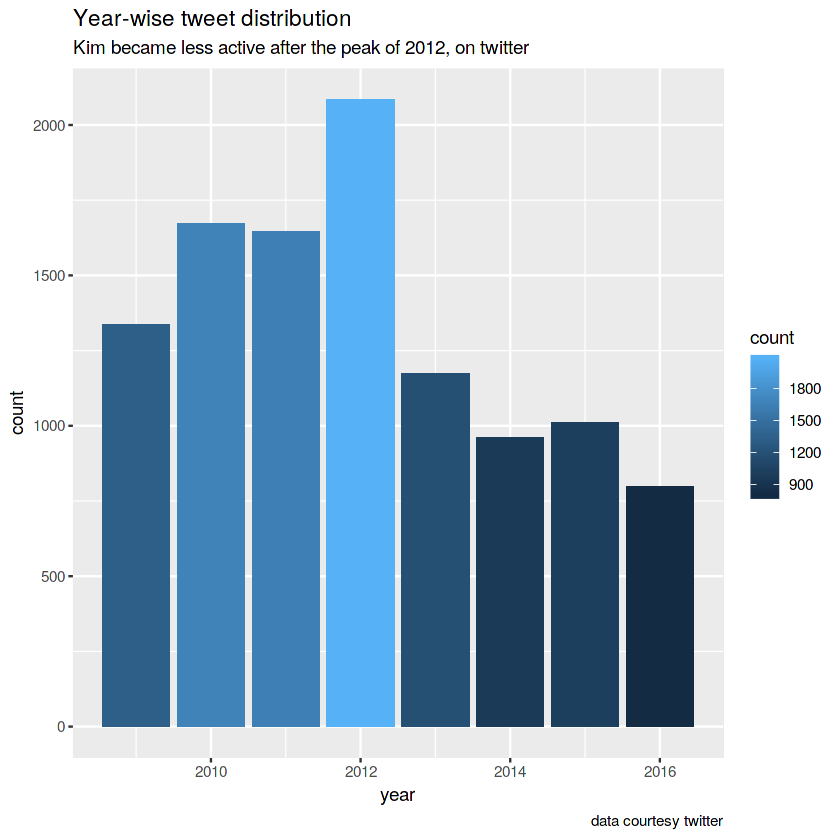

In [4]:
ggplot(dataset, aes(x = year, fill = ..count..)) + geom_histogram(stat = "count") + labs(title = "Year-wise tweet distribution", subtitle = "Kim became less active after the peak of 2012, on twitter", caption = "data courtesy twitter")

**What could be the reason for such huge decrease in Kim's twitter usage?**

I think 2012 is the period where the news of kim dating kanye started to surface over the media. Could this reason explain the peak of 2012? What about the sudden drop in tweets after 2012? What reasons could influence kim reducing her time on twitter? Well, of course, one reason could be the marriage of Kim and Kanye, but can this only reason explain such a large decrease in tweets? 

This answer can only be answered by Kim herself. We, only, can guess possible reasons. 

Now we do our first task. We reorganize the date variable of the starting rows to make it consistent over all the rows.  After doing that, we convert it into datetime format using lubridate.

In [5]:
#setting the date value of starting columns in correct order. 
d <- paste(substr(dataset$date[1:799], 4, 6), substr(dataset$date[1:799], 1, 3))
#stripping the beginning whitespace
d <- gsub("^\\s+", "", d)
#adding the corrected order date value
dataset$date[1:799] <- d
#adding the year variable to the date variable.
dataset$date[1:799] <- paste(dataset$date[1:799], dataset$year[1:799])
#making it a datetime object.
dataset$date <- dmy(dataset$date)

##On which day of the week Kim tweets the most?

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Use of `dataset$date` is discouraged. Use `date` instead.”


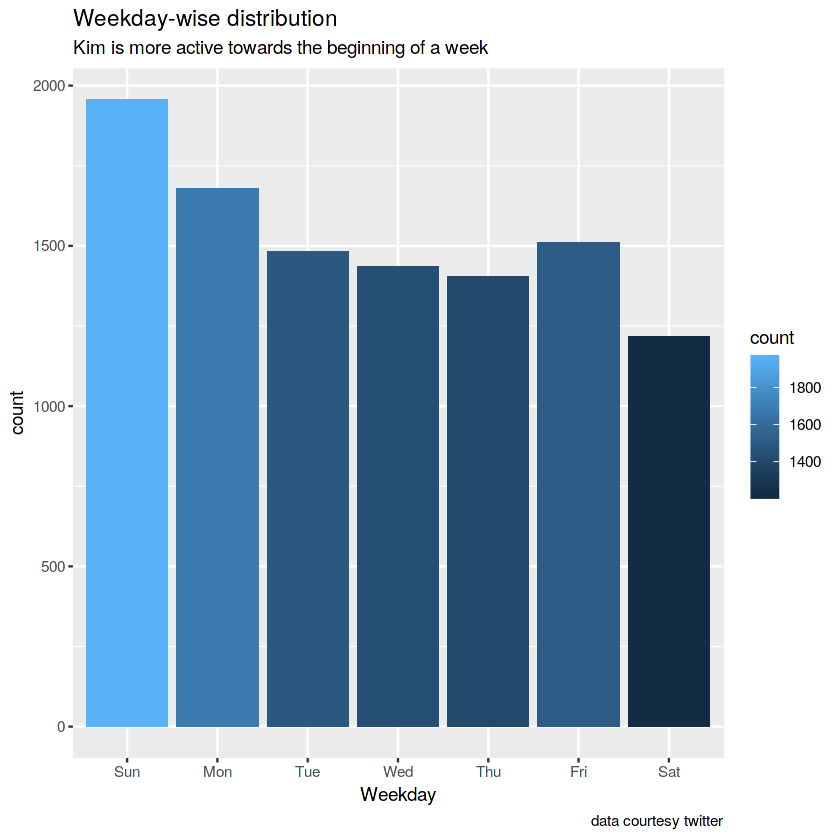

In [6]:
#weekday-wise distribution of tweets.
ggplot(dataset, aes(x = wday(dataset$date, label = T), fill = ..count..)) + geom_histogram(stat = "count") + labs(x = "Weekday", title = "Weekday-wise distribution", subtitle = "Kim is more active towards the beginning of a week", caption = "data courtesy twitter")

The trend decreases over the week except a small, compared to the neighbouring days, spike on friday.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Use of `dataset$date` is discouraged. Use `date` instead.”


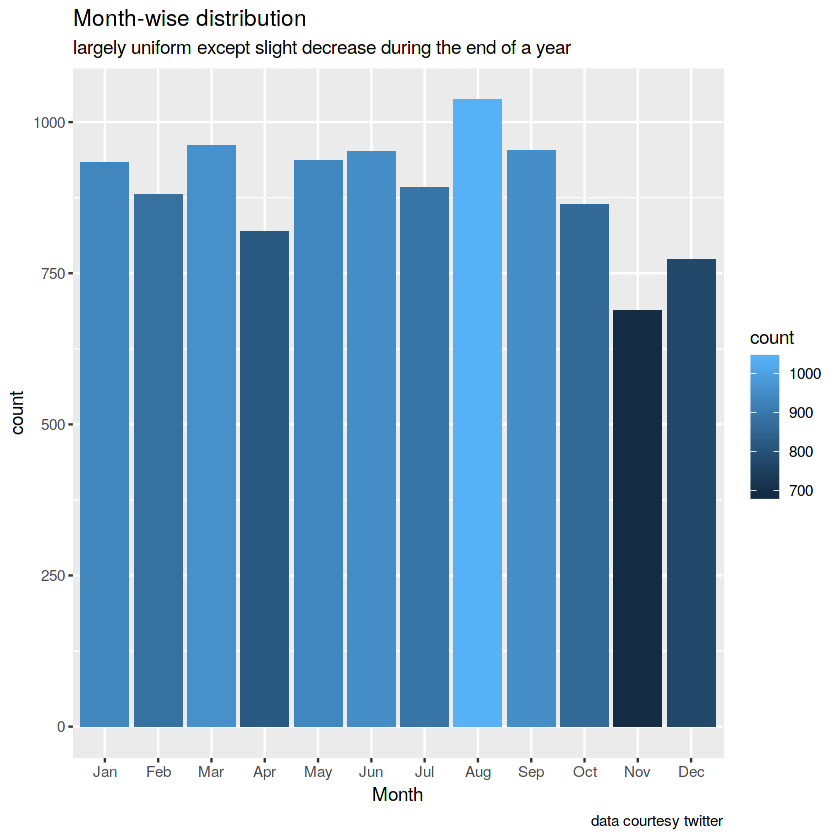

In [7]:
ggplot(dataset, aes(x = month(dataset$date, label = T), fill = ..count..)) + geom_histogram(stat = "count") + labs(x = "Month", title = "Month-wise distribution", subtitle = "largely uniform except slight decrease during the end of a year", caption = "data courtesy twitter")

The distribution looks largely uniform, except little increase and little decrease in kim's twitter activity in August and November, December respectively.

##What is kim's favourite day for tweeting?

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Use of `dataset$date` is discouraged. Use `date` instead.”


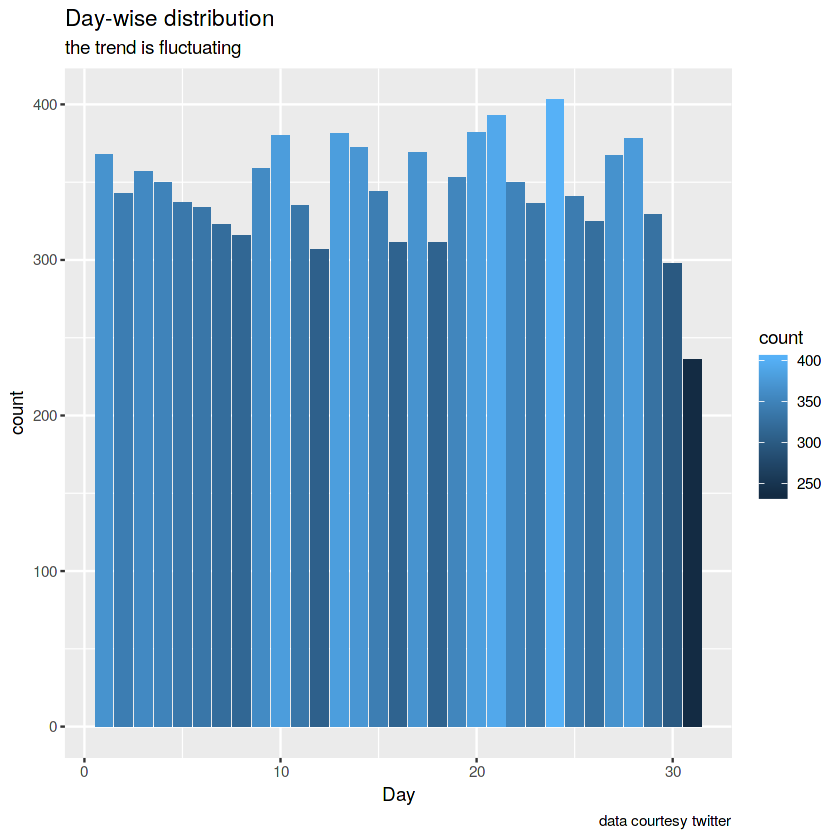

In [8]:
ggplot(dataset, aes(x = day(dataset$date), fill = ..count..)) + geom_histogram(stat = "count") + labs(title = "Day-wise distribution", x = "Day", subtitle = "the trend is fluctuating", caption= "data courtesy twitter")

#Sentiment analysis.

We do sentiment analysis now. We look at kim's tweets sentiment over different period and try to find interesting quirks. For this, we make a new data frame and add required information for our analysis.

In [9]:
d <- dataset$text
#new dataframe containing text.
d <- data.frame(text = d, stringsAsFactors = F)
#adding year variable.
d$year <- dataset$year

Making a new dataset helps to retain our original information. I always try to be lossless, in my analysis, as much as possible. If you want, you can do the following analysis with the original dataset and can add the following information to it.

In [10]:
#extracting the stopwords dataset from tidytext package.
data("stop_words")
#bing lexicon for sentiment analysis.
bing <- sentiments %>% filter(lexicon == "bing") %>% select(word, sentiment)

ERROR: Error: object 'lexicon' not found


##The sentiment analysis of kim's tweets over a year. 

In [11]:
#year-wise sentiment
sentiment_yearly <- d %>% group_by(year) %>% mutate(tweetno = row_number()) %>% ungroup() %>% unnest_tokens(word, text) %>% inner_join(bing) %>% count(year, index = tweetno %/% 10, sentiment) %>% spread(sentiment, n, fill = 0)  %>% mutate(sentiment = positive - negative) %>% ungroup()         
ggplot(sentiment_yearly, aes(x = index, y = sentiment, fill = factor(year))) + geom_bar(stat = "identity", show.legend = F) + facet_wrap(~year, ncol = 2, scales = "free") + labs(x = NULL, title = "Year-wise Sentiment analysis", caption = "data courtesy twitter")

ERROR: Error in tbl_vars_dispatch(x): object 'bing' not found


##The sentiment analysis of kim's tweets over a month?

In [12]:
d$month <- month(dataset$date, label = T)
#month-wise sentiment.
sentiment_monthly <- d %>% group_by(month) %>% mutate(tweetno = row_number()) %>% ungroup() %>% unnest_tokens(word, text) %>% inner_join(bing) %>% count(month, index = tweetno %/% 10, sentiment) %>% spread(sentiment, n, fill = 0) %>% mutate(sentiment = positive - negative) %>% ungroup()
ggplot(sentiment_monthly, aes(x = index, y = sentiment, fill = month)) + geom_bar(stat = "identity", show.legend = F) + facet_wrap(~month, scales = "free", nrow = 4)+ labs(x =NULL, title = "Month-wise sentiment analysis", caption = "data courtesy twitter")

ERROR: Error in tbl_vars_dispatch(x): object 'bing' not found


##The sentiment analysis of Kim's tweets over a weekday.

In [13]:
d$wday <- wday(dataset$date, label = T)
#weekday-wise sentiment
sentiment_wday <- d%>% group_by(wday) %>% mutate(tweetno = row_number()) %>% ungroup() %>% unnest_tokens(word, text) %>% inner_join(bing) %>% count(wday, index = tweetno%/% 10, sentiment) %>% spread(sentiment, n, fill = 0) %>% mutate(sentiment = positive - negative) %>% ungroup()
ggplot(sentiment_wday, aes(x = index, y = sentiment, fill = wday)) + geom_bar(stat = "identity", show.legend = F) + facet_wrap(~wday, ncol = 2, scales = "free")+ labs(x = NULL, title = "Week-wise sentiment analysis", subtitle = "All these plots suggest that Kim is almost always positive on twitter", caption = "data courtesy twitter")

ERROR: Error in tbl_vars_dispatch(x): object 'bing' not found


These plots tell us quite a lot about Kim Kardashian as a person. Kim is highly optimistic over twitter. We can count on hand the number of tweets where she was negative but we can't do the same for counting the positive tweets. Its quite wonderful how 140 characters tell us about the personality of a person.

#Going beyond n-grams.

Untill now, we focused on 1-gram tokens. We will now focus on the 2-gram tokens and the interaction between them. We look at the pairs of word and their frequency. We make a function to graph these pairs of word so that we don't repeat ourself.

In [14]:
#tidying the dataset with n-grams.
tidy <- d  %>% group_by(year) %>% mutate(tweetno = row_number()) %>% ungroup() %>% unnest_tokens(word, text) %>% anti_join(stop_words) %>% group_by(tweetno) %>% count(year, word, sort = T) %>% ungroup()

#our graphing function
graphing <- function(data, yr){
    data %>% filter(year == yr) %>% pairwise_count(word, tweetno, sort = T) %>% filter(n > 3) %>% graph_from_data_frame() %>%  ggraph(layout = "fr") + geom_edge_link(aes(edge_alpha = n, edge_width = n)) + geom_node_point(color = "darkslategray4", size = 5) + geom_node_text(aes(label = name), vjust = 1.8)  + theme_void()
}

Joining, by = "word"



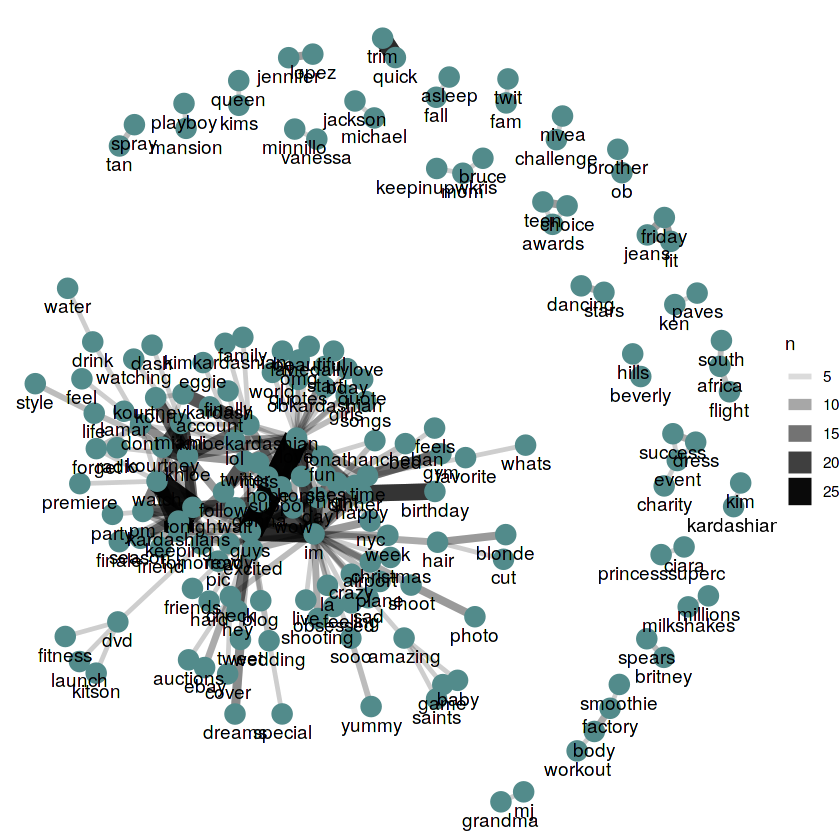

In [15]:
#year 2009
graphing(tidy, 2009)

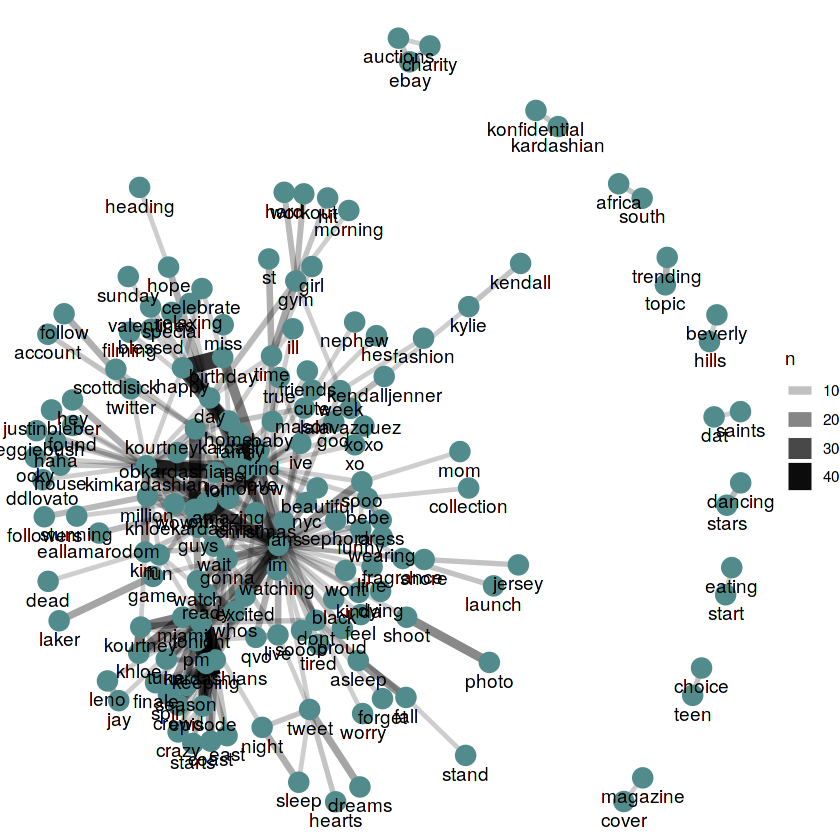

In [16]:
#year 2010
graphing(tidy, 2010)

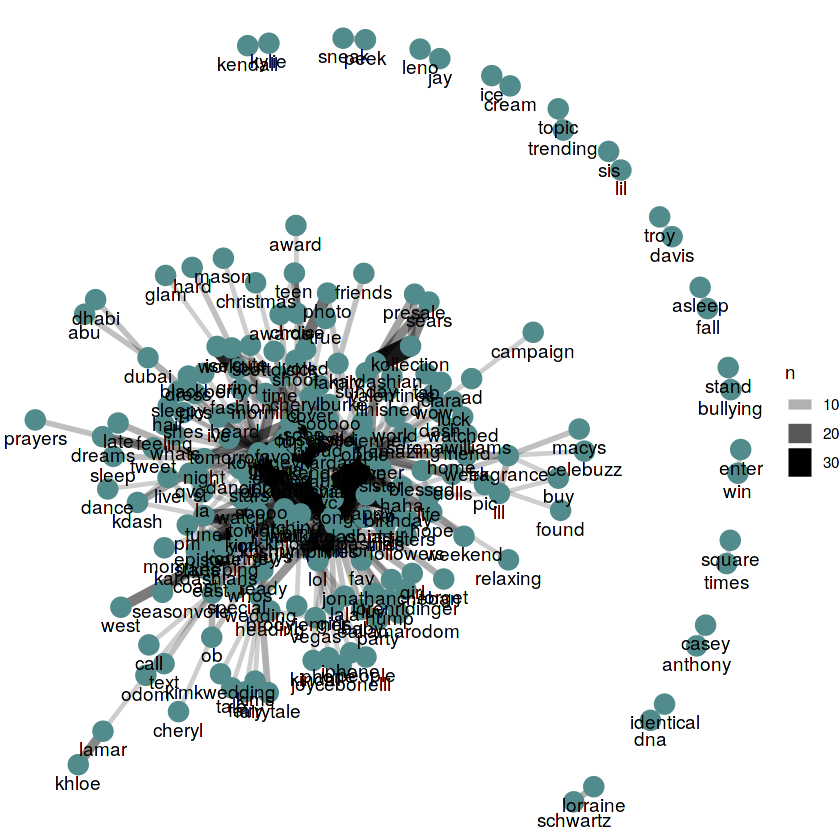

In [17]:
#year 2011
graphing(tidy, 2011)

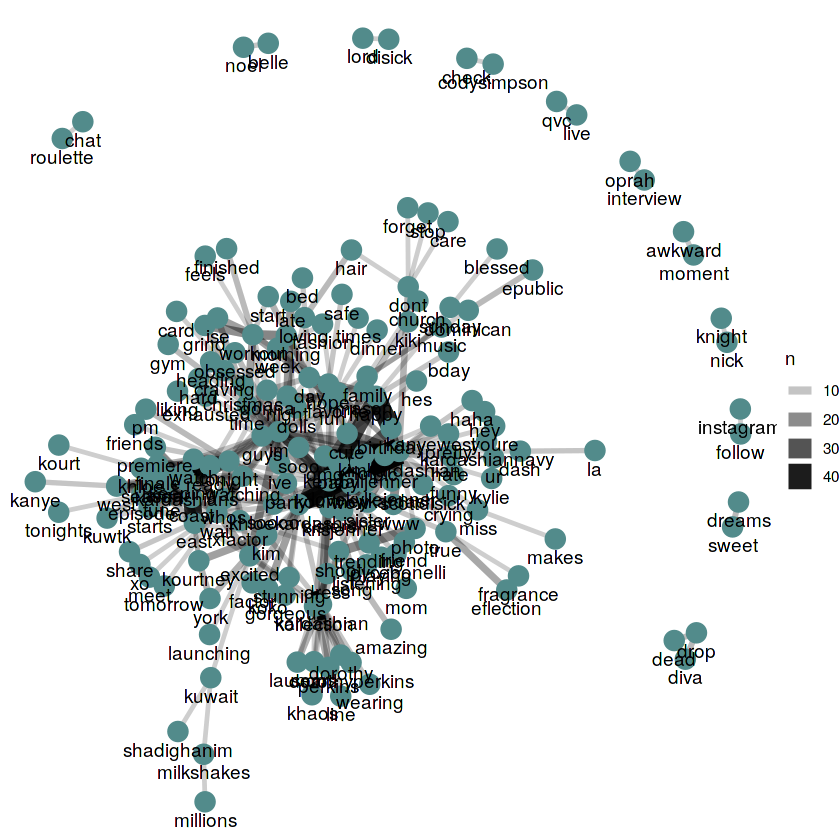

In [18]:
#year 2012
graphing(tidy, 2012)

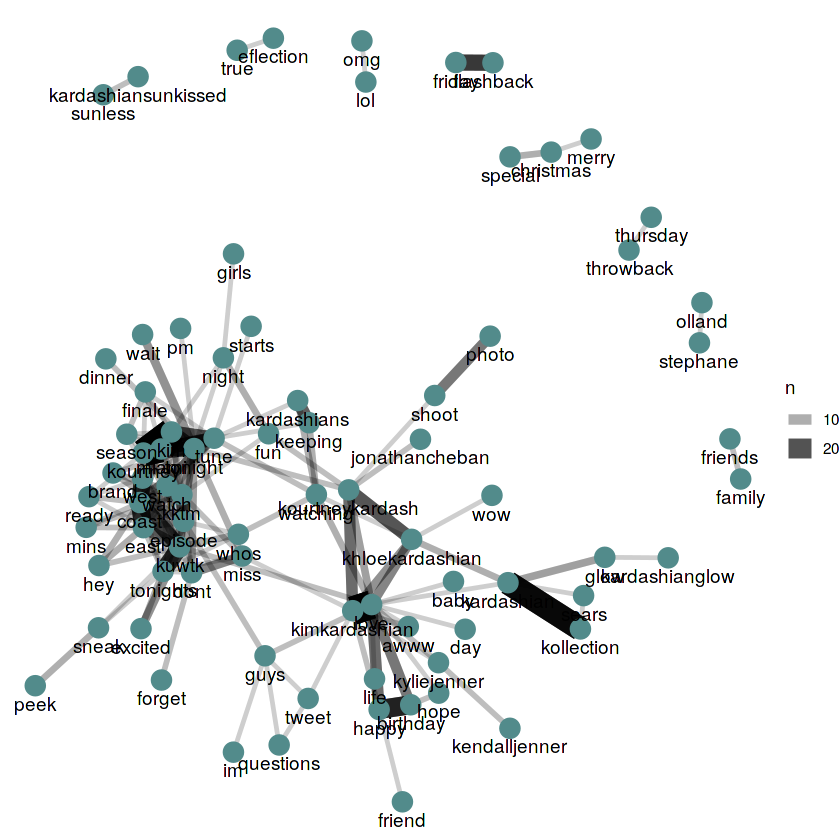

In [19]:
#year 2013
graphing(tidy, 2013)

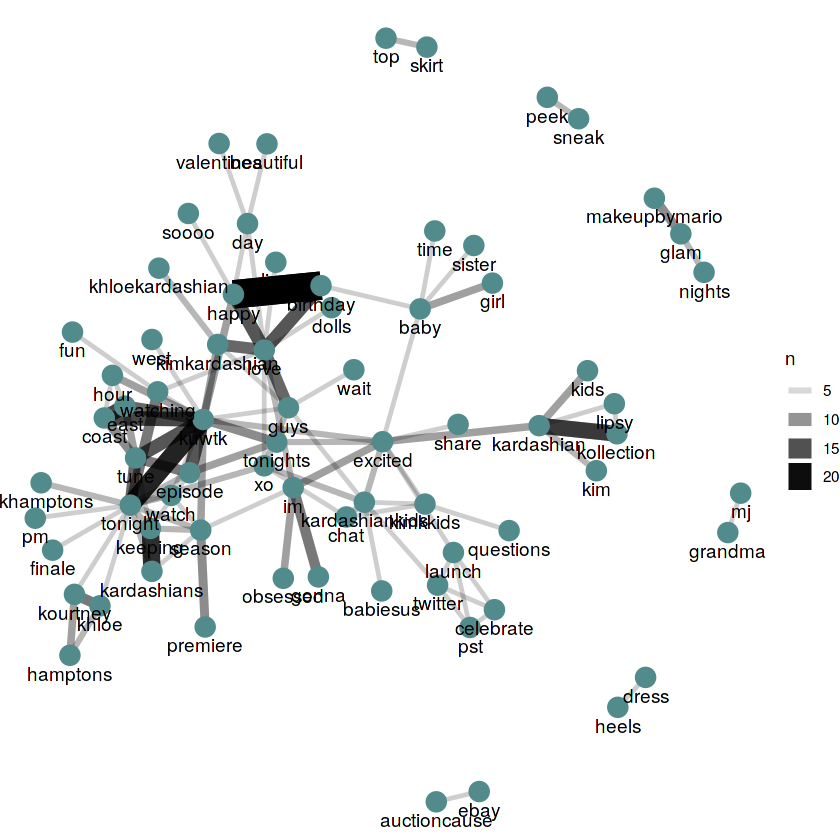

In [20]:
#year 2014
graphing(tidy, 2014)

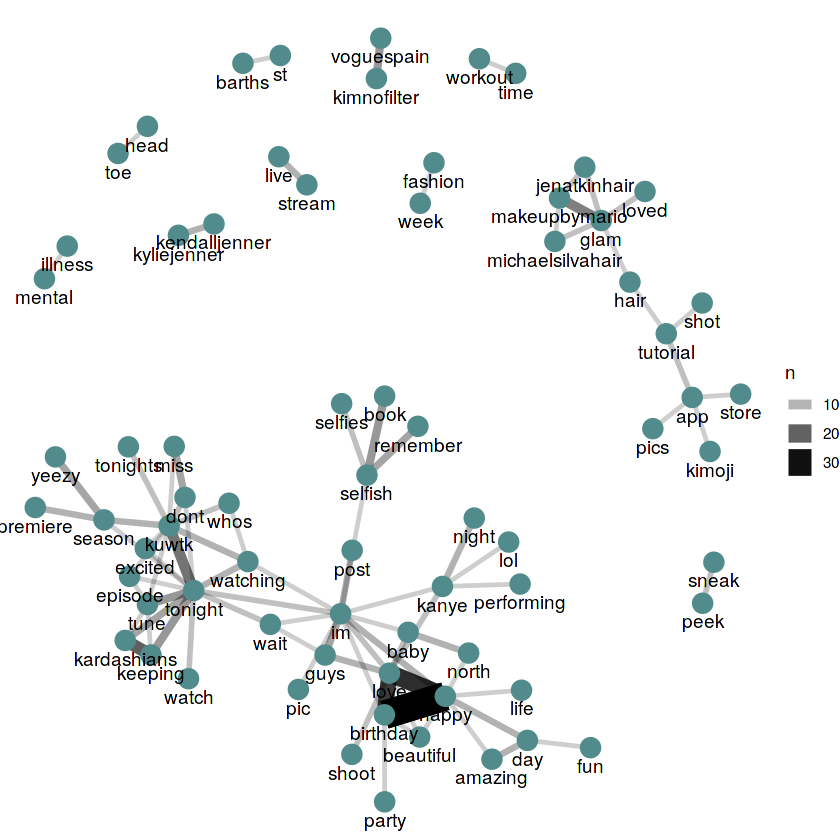

In [21]:
#year 2015
graphing(tidy, 2015)

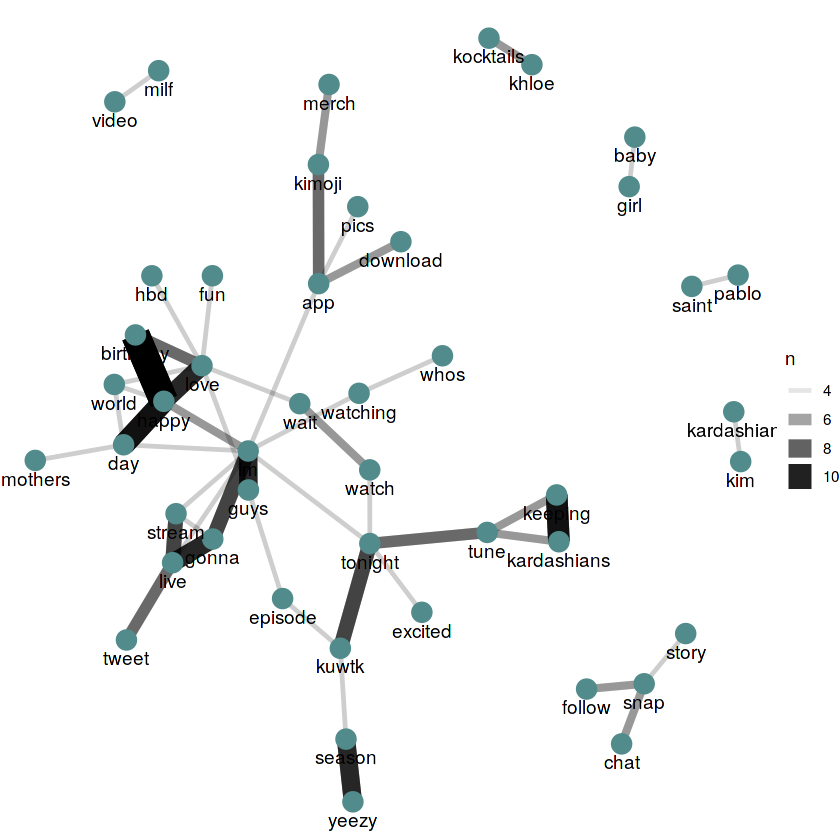

In [22]:
#year 2016
graphing(tidy, 2016)

The pair-wise count and decrease of paired words are consistent with our analysis that Kim reduced her twitter usage post 2012.

#Frequency analysis.

We do frequency analysis of the data. We will compare the frequency of words from one year
to the frequency of words from other years. This will tell us, which words were consistently
mentioned, over the years, in the tweets of Kim.

In [23]:
#words from 2009
words2009 <- tidy %>% filter(year == 2009)
words2009$year <- NULL

In [24]:
#words from 2016
words2016 <- tidy %>% filter(year == 2016)
#words from 2012
words2012 <- tidy %>% filter(year == 2012)

After getting the tokens for our analysis, we merge the tokens, to which we want to compare, into a single data frame.

In [25]:
#combining both the dataframes
words_both <- bind_rows(words2016, words2012)

In [26]:
#frequency calculation
similarity <- words_both %>% mutate(word = str_extract(word, "[a-z]+")) %>% count(year, word) %>% rename(other = nn) %>% inner_join(count(words2009, word)) %>% rename(words2009 = nn) %>% mutate(other = other/sum(other), words2009 = words2009/ sum(words2009)) %>% ungroup()

ERROR: Error in .f(.x[[i]], ...): object 'nn' not found


In [27]:
ggplot(similarity, aes(x = other, y = words2009, color = abs(words2009 - other))) +
    geom_abline(color = "gray40") +
    geom_jitter(alpha = 0.1, size = 2.5, width = 0.4, height = 0.4) +
    geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
    scale_x_log10(labels = percent_format()) +
    scale_y_log10(labels = percent_format()) +
    scale_color_gradient(limits = c(0, 0.001), low = "darkslategray4", high = "gray75") +
    facet_wrap(~year, ncol = 2) +
    theme_minimal(base_size = 14) +
    theme(legend.position="none") +
    labs(title = "Comparing Word Frequencies",
         subtitle = "Word frequencies of 2012 and 2016 versus 2009'",
         y = "frequency of 2009 words", x = NULL, caption = "data courtesy twitter")

ERROR: Error: You're passing a function as global data.
Have you misspelled the `data` argument in `ggplot()`


Words which are close to line occur quite frequently in 2009 and comparative year, and which are away from the line appear less frequently in kim's tweets of respective years. Words like bff, bed, beauty occur in 2012 and 2009 and words like ad, bc, coming, cute are unique to years 2016 and 2009.

#Named Entity Recognition(NER):
We will do NER and look at what are the places and names mentioned in the tweets
of Kim Kardashian. This is also a requirement for our hypothesis testing.

We make a custom function to **annotate** our text
and another function to extract **entities** from our document.

In [28]:
#function to annotate our document.
Annotated_doc <- function(doc){
corpus <- doc$text #the tidy corpus
corpus <- paste(corpus, collapse = "") #making it a single vector
corpus <- as.String(corpus) #using the string class for annotation
sent_annotator <- Maxent_Sent_Token_Annotator() #sentence annotator
word_annotator <- Maxent_Word_Token_Annotator() #word annotator
entity.place <- Maxent_Entity_Annotator(kind = "location") #Entity Annotator- location
entity.person <- Maxent_Entity_Annotator(kind ="person") #Entity Annotator- person
annotation <- NLP::annotate(corpus, list(sent_annotator, word_annotator, entity.place, entity.person)) #annotating the corpus
doc <- AnnotatedPlainTextDocument(corpus, annotation) #converting it into a text document
}

In [29]:
#Our Annotated documeht.
doc <- Annotated_doc(d)

ERROR: Error in as.String(corpus): could not find function "as.String"


In [30]:
# function to extract entities from an AnnotatedPlainTextDocument
entities <- function(doc, kind) {
    s <- doc$content
    a <- annotations(doc)[[1]]
    if(hasArg(kind)) {
        k <- sapply(a$features, `[[`, "kind")
        s[a[k == kind]]
    } else {
        s[a[a$type == "entity"]]
    }
}

In [31]:
#places mentioned in the tweets.
places <- entities(doc, "location")

ERROR: Error in entities(doc, "location"): object 'doc' not found


In [32]:
#persons mentioned in the tweets
person <- entities(doc, "person")

ERROR: Error in entities(doc, "person"): object 'doc' not found


In [33]:
#total places mentioned.
places %>% length()

#total person mentioned.
person %>% length()

ERROR: Error in eval(lhs, parent, parent): object 'places' not found


In [34]:
#unique places mentioned.
places %>% unique() %>% length()


#unique person mentioned.
person %>% unique() %>% length()

ERROR: Error in eval(lhs, parent, parent): object 'places' not found


After getting all the places, we plot the places on the map to know, which are the places Kim mentioned in her tweets.

In [35]:
#make a new data frame with all the places
location <- data.frame(places = places, stringsAsFactors = F)

#count the frequency of places
location <- location %>% group_by(places) %>% summarise(Count = n()) %>% arrange(desc(Count)) %>% ungroup()

#this code throws error in Kaggle but runs without any error in a natural R environment. You can copy and paste this code in 
#your R environment to get the map.
#geocode using Google's API to get latitude and logitude for plotting.
#suppressMessages(location <- cbind(location, geocode(location$places, source = "google")))

#filter away the NA values 
#location <- na.omit(location)

ERROR: Error in data.frame(places = places, stringsAsFactors = F): object 'places' not found


In [36]:
#world <- map_data("world")
#p <- ggplot(location) + geom_map(data = world, map = world, aes(map_id = region), fill = "white", colour = "black") 
#p <- p + geom_map(data = location, map = world, aes(map_id = places, fill = Count), colour = "black")
#p <- p + expand_limits(x = world$long, y = world$lat)
#p <- p + scale_fill_gradient(low = "#fff7bc", high = "#cc4c02", name = "Frequency")
#p

I am not a racist, but the algorithm annotated "Kanye" as a place. I am telling you this, because there are several such instances where algorithm miss-classified some Proper and Common nouns for place. This is not a problem for us because as you do the geocoding, the invalid place names are given NA values and then you filter out the NA values, that's why the na.omit operation at last.

Now, we take a look into the person names mentioned in the tweets of Kim.

In [37]:
#form the dataset with all the names which were mentioned in the tweets of Kim Kardashian.
person_names <- data.frame(name = person)

new_corpus <- person_names$name
#a corpus of all the names.
new_corpus <- Corpus(VectorSource(person_names$name))

ERROR: Error in as.data.frame.default(x[[i]], optional = TRUE): cannot coerce class ‘"function"’ to a data.frame


In [38]:
set.seed(7)
wordcloud(new_corpus, colors = brewer.pal(10,"Paired"))

ERROR: Error in wordcloud(new_corpus, colors = brewer.pal(10, "Paired")): could not find function "wordcloud"


I see "ive" and "Kim" but not "i" or "im". We plot an alternative plot to look for them.

In [39]:
#frequency of each names
person_names <- person_names %>% group_by(name) %>% summarise(count = n()) %>% arrange(desc(count))

ggplot(head(person_names, 30), aes(x = reorder(factor(name), count), y = count, fill = name, alpha = 0.3)) + geom_bar(stat = "identity") + theme(legend.position = "none") + labs(x = NULL) + coord_flip() 

ERROR: Error in eval(lhs, parent, parent): object 'person_names' not found


look, we found them.

#Is Kim Kardashian self-centeric?

A person can be said as self-centric, if he/she uses words like "i", "me", "my", his/her self name every time in his/her tweets.  Generally, people from film and entertainment industry are quite self-centric. You find many instances where they talk about them lot more than they talk about others. When we look into the tweets of Kim, you find several examples of words "me" and "my", but to prove our analysis, we dive deep into these names and try to find a pattern.

first we do hypothesis testing that are the frequencies of the names uniform and do they all appear in equal number of times in kim's tweets.

In [40]:
chisq.test(table(person), simulate.p.value = T)

ERROR: Error in unique.default(x, nmax = nmax): unique() applies only to vectors


**The P value is very low, so we reject our null hypothesis that the appearance of names are uniform.** By this, we know that that frequency of some names differ to other names. As we are interested in finding out wheter Kim is self-centric or not, we look at the frequency of self-cenric words to that of non-self-centric words and find out by how much they differ.

We detect the words which points towards kim and calculate the frequency of each word

In [41]:
#extracting those so called "self-centric" names.
kim <- str_extract_all(person_names$name, "(([Kk]im)|(I)|(Im)|(Kim Kardashian)|(KimKardashian)|([Mm]+y)|(Ive))+(.*)")
#unlist it
kim <- unlist(kim)
#count the frequency of the words
kim_words <- data.frame(table(kim))
#take a peak.
head(kim_words)
#we need a little bit of cleaning 
kim_words <- kim_words[-c(2, 3, 4, 5, 7, 8, 9, 10, 11, 12,14, 15, 16, 13, 17, 18, 19, 20, 53, 54),]

ERROR: Error in stri_extract_all_regex(string, pattern, simplify = simplify, : object 'person_names' not found


In [42]:
#the non-self-centric words.
others <- str_extract_all(person_names$name, "[^([Kk]im)|(I)|(Im)|(Kim Kardashian)|(KimKardashian)|([Mm]+y)|(Ive))]+(.*)")
#unlist it
others <- unlist(others)
#Frequency of words
others_words <- data.frame(table(others))
#take a peak
head(others_words)
#we need little, sorry, a very good clean up.
others_words <- others_words[-c(7:9, 21:23, 32:34, 37:47, 63:65, 71, 72, 85, 89, 565:573, 576:582, 593:597, 607:613, 616:624, 528:525, 512:523, 499:502, 457:460, 455, 443:448, 437, 426:429, 379:387, 368:372, 340, 344, 325, 326, 235, 225:227, 229, 222, 218, 215, 213, 206:208, 199, 184, 174, 176, 177, 178, 169, 166, 146:149, 132:138, 126, 118:122, 203:204), ] 

ERROR: Error in stri_extract_all_regex(string, pattern, simplify = simplify, : object 'person_names' not found


In [43]:
round(mean(kim_words$Freq)/mean(others_words$Freq), 2)

ERROR: Error in mean(kim_words$Freq): object 'kim_words' not found


This number means that in a speech, if Kim mentions others  40 times, she would mention herself, at least, 66 times. The ratio is approximately 4/2.41.

##Controlling for sample size and sentiment.

After knowing the ratio, we take a sample of 1000 tweets from only the years which tell us that Kim was highly positive in those years.

**I take the tweets from 2013, 2014, 2015 and 2016.** 

In [44]:
half_corpus <- d %>% filter(year %in% c(2013, 2014, 2015, 2016))

In [45]:
#set seed to get same samples.
set.seed(10)
#our sample size
sample.size <- 1000
#our sample indices
samples <- sample(1:nrow(half_corpus), sample.size)
#our samples
sampled_corpus <- half_corpus[samples,]

##Annotating sample 

We annotate our sample for names and places, as we did with our population dataset. Then we extract entities and find the p value for our hypothesis.

In [46]:
#annotated document
new_doc <- Annotated_doc(sampled_corpus)

ERROR: Error in as.String(corpus): could not find function "as.String"


In [47]:
#kim's self centric words
sample_kim <- str_extract_all(sample_person_names$names, "(([Kk]im)|(I)|(Im)|(Kim Kardashian)|(KimKardashian)|([Mm]y)|(Ive))+(.*)")
#unlist it
sample_kim <- unlist(sample_kim)
#frequency of words
sample_kim_words <- data.frame(table(sample_kim), stringsAsFactors = F)
#take a peak
head(sample_kim_words)
#little cleaning
sample_kim_words <- sample_kim_words[-c(2),]

ERROR: Error in stri_extract_all_regex(string, pattern, simplify = simplify, : object 'sample_person_names' not found


extract the entities

In [48]:
#person names
sample_persons <- entities(new_doc, "person")
#places names
sample_places <- entities(new_doc, "location")
#data frame of all the locations
sample_location <- data.frame(places = sample_places, stringsAsFactors = F)
#data frame of all the person names
sample_person_names <- data.frame(names = sample_persons, stringsAsFactors = F)

ERROR: Error in entities(new_doc, "person"): object 'new_doc' not found


In [49]:
#non-self-centric words
sample_others <- str_extract_all(sample_person_names$names, "[^([Kk]im)|(I)|(Im)|(Kim Kardashian)|(KimKardashian)|([Mm]y)|(Ive))]+(.*)")
#unlist it
sample_others <- unlist(sample_others)
#Frequency of these words
sample_others_words <- data.frame(table(sample_others), stringsAsFactors = F)
#little bit of cleaning
sample_others_words <- sample_others_words[-c(5, 16, 18, 22, 23,  25, 26, 27, 31, 39, 40, 41, 44, 46, 48, 45, 49), ] 

ERROR: Error in stri_extract_all_regex(string, pattern, simplify = simplify, : object 'sample_person_names' not found


After knowing the frequency of words, we combine both the data frame containing self-phobic words and the data frame containing non-self-phobic words and make a single data frame to fit our model to get our p-value.

In [50]:
#data frame with all words.
all_words <- bind_rows(sample_kim_words, sample_others_words)

ERROR: Error in dots_values(...): object 'sample_kim_words' not found


Once we have a single data set with frequency and with words, we fit our model with our acquired ratio and look at he p-value of our fit.

In [51]:
#our model
chisq.test(all_words$Freq,c(rep(4, 11), rep(2.41, 33)), rescale.p = T, simulate.p.value = T)

ERROR: Error in is.data.frame(x): object 'all_words' not found


The p-value increased quite a lot from our earlier model, but, still, it is not enough to label Kim as a self-phobic, it would be quite unfair to her.

In [52]:
#the ratio of words of our sample.
round(mean(sample_kim_words$Freq)/mean(sample_others_words$Freq), 2)

ERROR: Error in mean(sample_kim_words$Freq): object 'sample_kim_words' not found


We conclude that Kim Kardashian is not a self-centric person, through our test, although we can surely say that if she mentions someone else 2 time, it is more likely that kim would mention her-self, at least, 2 time in the same tweet, though it can be more.

We have another entertainment person Neil De Grasse Tyson in our dataset. I will compare the insights and trends from the analysis of this kim's tweets to that of Neil's tweets.

##Thanks to:

I want to thank @DataCanary and @Myles, the two Kaggle admin, who stayed with me in the forums and looked at my problems with this kernel. I pestered them quite a lot with my posts but they always answered me. Now you know, why Kaggle is home for Data Scientists, a family member always helps other family members.